In [1]:
#import the dataset from the kaggle dataset directly in the jupiter host
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightinformation.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
 57 1552k   57  895k    0     0   400k      0  0:00:03  0:00:02  0:00:01  399k
100 1552k  100 1552k    0     0   508k      0  0:00:03  0:00:03 --:--:--  508k


In [2]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#load the imported dataset
data = pd.read_csv('flightinformation.csv')

In [8]:
data.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [7]:
#check for the null values in the feature columns
data.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

In [9]:
#Selecting the required column
data = data[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
data.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64

In [10]:
#drop all the null values from the ARR_DEL15
data.dropna(subset=['ARR_DEL15'], how='all', inplace=True)


C:\Users\vigne\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
#check for the null values after taken care of NAN
data.isnull().sum()

MONTH           0
DAY_OF_MONTH    0
DAY_OF_WEEK     0
ORIGIN          0
DEST            0
CRS_DEP_TIME    0
ARR_DEL15       0
dtype: int64

In [13]:
#Change the CRS_DEP_TIME into single time stamp
for index, row in data.iterrows():
    data.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
data.head()

C:\Users\vigne\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,19,0.0
1,1,1,5,DTW,MSP,13,0.0
2,1,1,5,ATL,SEA,9,0.0
3,1,1,5,SEA,MSP,8,0.0
4,1,1,5,SEA,DTW,23,0.0


In [14]:
#There are currently two columns showing the flight’s origin and destination. 
#Although it is workable in its current form, it is better to create indicator columns corresponding to the airports and remove the originals
data = pd.get_dummies(data, columns=['ORIGIN', 'DEST'])
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0.0,0,0,0,0,1,0,1,0,0,0


In [15]:
train_x, test_x, train_y, test_y = train_test_split(data.drop('ARR_DEL15', axis=1), data['ARR_DEL15'], test_size=0.2, random_state=42)

In [16]:
model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

C:\Users\vigne\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

In [17]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.87324581258488

In [18]:
probabilities = model.predict_proba(test_x)

In [24]:
probabilities

array([[1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [0.7, 0.3],
       [0.6, 0.4],
       [0.8, 0.2]])

In [19]:
roc_auc_score(test_y, probabilities[:, 1])


0.6381438109674955

In [20]:
confusion_matrix(test_y, predicted)


array([[1909,   33],
       [ 247,   20]], dtype=int64)

In [21]:
train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

0.9978260869565218

In [22]:
sns.set()

Text(0, 0.5, 'True Positive Rate')

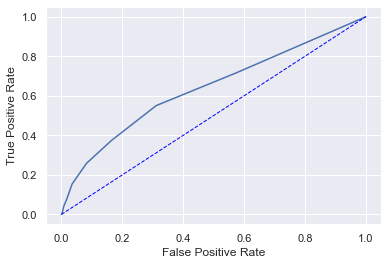

In [23]:
fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [25]:
def delay_prediction(departure_date_time, origin, destination):
    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    model_result = (model.predict_proba(pd.DataFrame(input))[0][0])
    
    print ('The probability of your flight being delayed is:' , model_result*100 , '%')

In [26]:
data_copy = data.copy()

data_copy['ARR_DEL15'].loc[(data_copy['ARR_DEL15'] == 0)] = 'Not-Delayed'
data_copy['ARR_DEL15'].loc[(data_copy['ARR_DEL15'] == 1)] = 'Delayed'

data_copy['ORIGIN_ATL'].loc[(data_copy['ORIGIN_ATL'] == 1)] = 'Origin'
data_copy['ORIGIN_DTW'].loc[(data_copy['ORIGIN_DTW'] == 1)] = 'Origin'
data_copy['ORIGIN_JFK'].loc[(data_copy['ORIGIN_JFK'] == 1)] = 'Origin'
data_copy['ORIGIN_MSP'].loc[(data_copy['ORIGIN_MSP'] == 1)] = 'Origin'
data_copy['ORIGIN_SEA'].loc[(data_copy['ORIGIN_SEA'] == 1)] = 'Origin'

data_copy['DEST_ATL'].loc[(data_copy['DEST_ATL'] == 1)] = 'Destination'
data_copy['DEST_DTW'].loc[(data_copy['DEST_DTW'] == 1)] = 'Destination'
data_copy['DEST_JFK'].loc[(data_copy['DEST_JFK'] == 1)] = 'Destination'
data_copy['DEST_MSP'].loc[(data_copy['DEST_MSP'] == 1)] = 'Destination'
data_copy['DEST_SEA'].loc[(data_copy['DEST_SEA'] == 1)] = 'Destination'

data_copy['ORIGIN_ATL'].loc[(data_copy['ORIGIN_ATL'] == 0)] = '-'
data_copy['ORIGIN_DTW'].loc[(data_copy['ORIGIN_DTW'] == 0)] = '-'
data_copy['ORIGIN_JFK'].loc[(data_copy['ORIGIN_JFK'] == 0)] = '-'
data_copy['ORIGIN_MSP'].loc[(data_copy['ORIGIN_MSP'] == 0)] = '-'
data_copy['ORIGIN_SEA'].loc[(data_copy['ORIGIN_SEA'] == 0)] = '-'

data_copy['DEST_ATL'].loc[(data_copy['DEST_ATL'] == 0)] = '-'
data_copy['DEST_DTW'].loc[(data_copy['DEST_DTW'] == 0)] = '-'
data_copy['DEST_JFK'].loc[(data_copy['DEST_JFK'] == 0)] = '-'
data_copy['DEST_MSP'].loc[(data_copy['DEST_MSP'] == 0)] = '-'
data_copy['DEST_SEA'].loc[(data_copy['DEST_SEA'] == 0)] = '-'


data_copy.head(100)

C:\Users\vigne\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,Not-Delayed,Origin,-,-,-,-,-,-,-,-,Destination
1,1,1,5,13,Not-Delayed,-,Origin,-,-,-,-,-,-,Destination,-
2,1,1,5,9,Not-Delayed,Origin,-,-,-,-,-,-,-,-,Destination
3,1,1,5,8,Not-Delayed,-,-,-,-,Origin,-,-,-,Destination,-
4,1,1,5,23,Not-Delayed,-,-,-,-,Origin,-,Destination,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,5,2,17,Not-Delayed,Origin,-,-,-,-,-,-,Destination,-,-
96,1,5,2,8,Not-Delayed,-,Origin,-,-,-,Destination,-,-,-,-
97,1,5,2,19,Not-Delayed,-,-,Origin,-,-,Destination,-,-,-,-
98,1,6,3,11,Not-Delayed,-,-,-,Origin,-,Destination,-,-,-,-


In [27]:
delay_prediction('01/05/2016 17:00:00', 'ATL', 'DTW')

The probability of your flight being delayed is: 80.0 %
